# Urban Sound Challenge

# 2. Model Training

### Angabe:

Auf folgender URL: https://urbansounddataset.weebly.com/ befinden sich Audio Dateien im WAV Format für Geräusche, die in einer Stadt aufgenommen wurden, z.B: Bohrhammer, Klimaanlage, spielende Kinder, Hundegebell, Schüsse eines Gewehrs, usw. 
Als Alternative steht ein stark reduziertes Dataset dieser Files im Archiv `urban_sound_files.zip` auf `https://filebox.fhooecloud.at` zur Verfügung.

Laden Sie diese Files bzw. verwenden Sie urban_sound_files.zip und erstellen Sie Modelle, die eine Klassifikation der einzelnen Geräusche mit Hilfe von Neuronalen Netzen ermöglichen.  
Verwenden und vergleichen Sie folgende Modelle:

    a) Multilayer Perceptron  
    b) Rekurrente Netzwerke: LSTM, GRU und Standard RNNs  
    c) CNNs  

In [1]:
import os
from pathlib import Path
from typing import List, Tuple, Any, Optional, Generator , Callable
from comet_ml import Experiment, Optimizer
import pandas as pd
import numpy as np
import librosa
import librosa.display
from collections import namedtuple
from sklearn.preprocessing import LabelEncoder
from keras import optimizers
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split 
from keras.callbacks import EarlyStopping, ModelCheckpoint
from datetime import datetime 
from functools import partial
import matplotlib as plt

from tqdm import tqdm
from sklearn.metrics import confusion_matrix

from src.utils import load_data, extract_features

Using TensorFlow backend.


In [36]:
%matplotlib inline
plt.style.use('ggplot')

In [3]:
## 2.0 Training Configurations

## 2.0 Training Configurations

In [4]:
from src.models import MLPModel, CNNModel, LSTMModel, RNNModel, GRUModel

In [5]:
ModelConfig = namedtuple('ModelTrainConfig', ['model_class', 'hyper_params', 'prep_params'])

models = {
    'mlp': ModelConfig(
        MLPModel,
        hyper_params={ 'epochs': 200, 'batch_size': 32},
        prep_params={ 'output_ndim': 1 }
    ),
    'cnn': ModelConfig(
        CNNModel,
        hyper_params = { 'epochs': 200, 'batch_size': 64 },
        prep_params = { 'output_ndim': 2, 'pad_mode': 'constant' }
    ),
    'rnn': ModelConfig(
        RNNModel,
        hyper_params= { 'epochs': 1000, 'batch_size': 32 },
        prep_params = { 'output_ndim': 2 }
    ),
    'lstm': ModelConfig(
        LSTMModel,
        hyper_params= { 'epochs': 200, 'batch_size': 32 },
        prep_params = { 'output_ndim': 2, 'pad_mode': 'constant' }
    ),
    'gru': ModelConfig(
        GRUModel,
        hyper_params= {  'epochs': 200, 'batch_size': 32 },
        prep_params = { 'output_ndim': 2 }
    ),
}

In [6]:
m = models['rnn']
model_name = m.model_class.__name__

In [7]:
FIG_DIR = Path('./reports/figures/') / model_name
MODELS_DIR = Path("./models/")

## 2.1 Preparations

Settings for `comet.ml`

In [8]:
# settings for tracking experiments via comet.ml
COMET_SETTINGS = {
    "api_key": "k4DgVz1cmTM6MS4shK1A1K0aQ",
    "project_name": "urbansound", 
    "workspace": "slashme"
}

experiment = Experiment(**COMET_SETTINGS)

COMET INFO: old comet version (3.0.1) detected. current: 3.0.2 please update your comet lib with command: `pip install --no-cache-dir --upgrade comet_ml`
COMET INFO: Experiment is live on comet.ml https://www.comet.ml/slashme/urbansound/dfd344228de040078ff6de23c9141034



##### Settings for Hyperparameter Optimizer

In [9]:
# We only need to specify the algorithm and hyperparameters to use:
config = {
    "algorithm": "bayes",

    # Declare your hyperparameters in the Vizier-inspired format:
    "parameters": {
        "x": {"type": "integer", "min": 1, "max": 5},
    },

    # Declare what we will be optimizing, and how:
    "spec": {
        "metric": "loss",
        "objective": "minimize",
        "seed": 42,
    },
}

# Next, create an optimizer, passing in the config:
# (You can leave out API_KEY if you already set it)
opt = Optimizer(config, api_key=COMET_SETTINGS['api_key'])

COMET INFO: COMET_OPTIMIZER_ID=107d140dace54e6fb0ee5de37ef30427
COMET INFO: Using optimizer config: {'algorithm': 'bayes', 'configSpaceSize': 'infinite', 'endTime': None, 'id': '107d140dace54e6fb0ee5de37ef30427', 'lastUpdateTime': None, 'maxCombo': 0, 'name': '107d140dace54e6fb0ee5de37ef30427', 'parameters': {'x': {'max': 5, 'min': 1, 'scalingType': 'uniform', 'type': 'integer'}}, 'predictor': None, 'spec': {'gridSize': 10, 'maxCombo': 0, 'metric': 'loss', 'minSampleSize': 100, 'objective': 'minimize', 'retryAssignLimit': 0, 'retryLimit': 20, 'seed': 42}, 'startTime': 15199083319, 'state': {'sequence_i': 0, 'sequence_pid': None, 'sequence_retry': 0}, 'status': 'running', 'suggestion_count': 0, 'trials': 1, 'version': '1.0.24'}


In [10]:
 
# for experiment in optimizer.get_experiments(project_name=COMET_SETTINGS['project_name']):

# # Test the model
# loss = fit(experiment.get_parameter("size"),
#          experiment.get_parameter("lr"))

# # Report the loss, if not auto-logged:
# experiment.log_metric("loss", loss)


#### Prepare environment for training

Set and create (if necessary) auxiliary folders and start tracking the new experiment

In [11]:
model_dest_file = str(MODELS_DIR/f"{model_name}.h5")   # Keras requires the path to be a string
fig_dir = Path(f"./reports/figures/{model_name}/")

if not os.path.exists(MODELS_DIR):
    os.mkdir(MODELS_DIR)
if not os.path.exists(fig_dir):
    os.mkdir(fig_dir)

track model training via comet.ml

In [12]:
experiment.set_name(model_name)
experiment.log_parameters(m.hyper_params)

### 2.1.1 Load Data

In [13]:
data_dir = Path('./data/raw')
data = load_data(data_dir, "train_long.csv", "train_long_cached.pkl")

Loading cached data!


In [14]:
classes = [
    'air_conditioner',
    'car_horn',
    'children_playing',
    'dog_bark',
    'drilling',
    'engine_idling',
    'gun_shot',
    'jackhammer',
    'siren',
    'street_music'
]

### 2.1.2 Extract Features

In [15]:
def preprocess_features(df, cache_name: Optional[str]=None, **kwargs):
    CACHE_DIR = Path('./data/interim/')
    if cache_name is None:  # create default cache name
        dim = str(kwargs.get('output_ndim', 2))+"d"
        pad_mode = kwargs.get('pad_mode', 'constant')
        cache_name = f"_prepped_{dim}_{pad_mode}.pkl"
        
    if os.path.exists(CACHE_DIR/cache_name):
        print(f"Loading cached data!")
        return pd.read_pickle(CACHE_DIR/cache_name)
    df_extracted = df.apply(lambda x: extract_features(x.raw, x.sample_rate, **kwargs), axis=1)
    
    df = pd.concat([df, df_extracted], axis=1)
    if cache_name is not None:
        print(f"Saved prepped data to '{cache_name}'")
        df.to_pickle(CACHE_DIR/cache_name)
    return df

In [16]:
df = preprocess_features(data, max_pad=174)

Loading cached data!


In [17]:
df

,ID,Class,raw,sample_rate,duration,features,n_mfccs,n_frames,n_samples
0,0,siren,"[-0.012129276, -0.027601117, -0.025355084, -0....",22050,4.000000,"[[-76.076836, -69.314156, -72.66219, -73.40612...",40,174,88200
1,1,street_music,"[-0.09602016, -0.14303702, 0.05203498, 0.10233...",22050,4.000000,"[[12.925442, -5.3520455, -34.82658, -49.400352...",40,174,88200
2,2,drilling,"[-0.0006929353, -0.0012265302, -0.0011871828, ...",22050,4.000000,"[[-482.6237, -446.6598, -431.8628, -428.26984,...",40,174,88200
3,3,siren,"[0.02706518, 0.048945263, -0.052624583, -0.208...",22050,4.000000,"[[-75.61564, -87.232124, -111.308784, -115.822...",40,174,88200
4,4,dog_bark,"[0.07636129, 0.117822915, 0.10266275, 0.106471...",22050,4.000000,"[[-257.4971, -231.21112, -196.4951, -173.29199...",40,174,88200
...,...,...,...,...,...,...,...,...,...
3632,8720,street_music,"[-0.07785502, -0.11421067, -0.10142167, -0.110...",22050,4.000000,"[[-362.47433, -380.73764, -397.3177, -407.8087...",40,174,88200
3633,8722,dog_bark,"[0.0019674515, 0.003834403, 0.0017573227, 0.00...",22050,3.480000,"[[-364.3833, -227.78868, -134.64859, -90.52688...",40,174,76734
3634,8723,street_music,"[-0.13602088, -0.19903006, -0.17202714, -0.187...",22050,4.000000,"[[-197.00887, -176.01727, -150.27272, -130.609...",40,174,88200
3635,8726,dog_bark,"[-9.743463e-05, -0.00013001809, -7.625971e-05,...",22050,2.206485,"[[-605.8613, -601.63245, -556.4389, -343.25024...",40,174,48653



### 2.1.4 Split the Dataset 

In [18]:
print(f"Preparing data for {model_name} model")
#x, y = prepare_data(df, m.model_class.reshape_data)

# Convert features and corresponding classification labels into numpy arrays
x = np.array(df.features.tolist())
x = m.model_class.reshape_data(x)
y = np.array(df.Class.tolist())

# Encode the classification labels
le = LabelEncoder()
y_1h = to_categorical(le.fit_transform(y))

print(f"x-shape: {x.shape} / 1st element: {x[0].shape}")

x_train, x_test, y_train, y_test = train_test_split(x, y_1h, test_size=0.2, random_state = 42)

print(f"x_train: {x_train.shape},   x_test: {x_test.shape}")
print(f"Training {model_name} model")

Preparing data for RNNModel model
x-shape: (3637, 174, 40) / 1st element: (174, 40)
x_train: (2909, 174, 40),   x_test: (728, 174, 40)
Training RNNModel model


## 2.2 Train Model

Preparing data to meet the requirements for the given model

In [19]:
# create model
no_classes = len(classes)  # number of columns of one hot encoded labels = number of classes
input_shape = x[0].shape

print(f"Input Shape: {input_shape}")
model = m.model_class.create(no_classes, input_shape)
model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam')


Input Shape: (174, 40)
Input shape: (174, 40)


In [20]:
# Calculate pre-praining accuracy
score = model.evaluate(x_test, y_test, verbose=1)
accuracy = 100*score[1]
print(f"Pre-training accuracy: {accuracy:.4f}%")
experiment.log_metric("Pre-training accuracy", accuracy)

728/728 [==============================] - 0s 486us/step
Pre-training accuracy: 11.5385%


In [21]:
model.summary()

Model: "RNN"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_1 (SimpleRNN)     (None, 174)               37410     
_________________________________________________________________
dense_1 (Dense)              (None, 256)               44800     
_________________________________________________________________
dense_2 (Dense)              (None, 10)                2570      
Total params: 84,780
Trainable params: 84,780
Non-trainable params: 0
_________________________________________________________________


In [22]:
# train model
callbacks = [
    EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=0),
    ModelCheckpoint(model_dest_file, verbose=1, save_best_only=True),
]

start = datetime.now()
history = model.fit(x_train, y_train, validation_data=(x_test, y_test), **m.hyper_params, callbacks=callbacks, verbose=1)
duration = datetime.now() - start
print(f"Training took {duration}") 

# return model, history, (x_train, y_train), (x_test, y_test)

COMET INFO: Ignoring automatic log_parameter('verbose') because 'keras:verbose' is in COMET_LOGGING_PARAMETERS_IGNORE
COMET INFO: Ignoring automatic log_parameter('do_validation') because 'keras:do_validation' is in COMET_LOGGING_PARAMETERS_IGNORE


Train on 2909 samples, validate on 728 samples
Epoch 1/1000
  32/2909 [..............................] - ETA: 20s - loss: 17.3336 - accuracy: 0.1250

COMET INFO: Ignoring automatic log_metric('batch_batch') because 'keras:batch_batch' is in COMET_LOGGING_METRICS_IGNORE
COMET INFO: Ignoring automatic log_metric('batch_size') because 'keras:batch_size' is in COMET_LOGGING_METRICS_IGNORE


2909/2909 [==============================] - 4s 1ms/step - loss: 3.5507 - accuracy: 0.2076 - val_loss: 1.8867 - val_accuracy: 0.3187

Epoch 00001: val_loss improved from inf to 1.88669, saving model to models\RNNModel.h5
Epoch 2/1000
2909/2909 [==============================] - 4s 1ms/step - loss: 2.0680 - accuracy: 0.3022 - val_loss: 1.8418 - val_accuracy: 0.3640

Epoch 00002: val_loss improved from 1.88669 to 1.84178, saving model to models\RNNModel.h5
Epoch 3/1000
2909/2909 [==============================] - 4s 1ms/step - loss: 1.7991 - accuracy: 0.3592 - val_loss: 1.5704 - val_accuracy: 0.4423

Epoch 00003: val_loss improved from 1.84178 to 1.57044, saving model to models\RNNModel.h5
Epoch 4/1000
2909/2909 [==============================] - 4s 1ms/step - loss: 1.7200 - accuracy: 0.3702 - val_loss: 1.5527 - val_accuracy: 0.4409

Epoch 00004: val_loss improved from 1.57044 to 1.55266, saving model to models\RNNModel.h5
Epoch 5/1000
2909/2909 [==============================] - 4s 1ms/

2909/2909 [==============================] - 4s 1ms/step - loss: 1.1771 - accuracy: 0.5658 - val_loss: 1.2597 - val_accuracy: 0.5549

Epoch 00038: val_loss did not improve from 1.17059
Epoch 39/1000
2909/2909 [==============================] - 4s 1ms/step - loss: 1.1863 - accuracy: 0.5620 - val_loss: 1.2074 - val_accuracy: 0.5865

Epoch 00039: val_loss did not improve from 1.17059
Epoch 40/1000
2909/2909 [==============================] - 4s 1ms/step - loss: 1.1708 - accuracy: 0.5634 - val_loss: 1.2165 - val_accuracy: 0.5687

Epoch 00040: val_loss did not improve from 1.17059
Epoch 41/1000
2909/2909 [==============================] - 4s 1ms/step - loss: 1.1458 - accuracy: 0.5792 - val_loss: 1.2106 - val_accuracy: 0.5755

Epoch 00041: val_loss did not improve from 1.17059
Epoch 42/1000
2909/2909 [==============================] - 4s 1ms/step - loss: 1.1566 - accuracy: 0.5679 - val_loss: 1.3088 - val_accuracy: 0.5508

Epoch 00042: val_loss did not improve from 1.17059
Epoch 43/1000
2909/

## 2.3 Evaluate Model

In [23]:
from src.utils import plot_confusion_matrix, plot_metric
#from sklearn.metrics import plot_confusion_matrix
import matplotlib.pyplot as plt

In [24]:
def score_model(model, train_xy: Tuple, test_xy: Tuple) -> None:
    """Evaluating the model on the training and testing set"""
    
    loss, acc = model.evaluate(*train_xy, verbose=0)
    print(f"Training Accuracy: {acc:.3f} / Loss: {loss:.3f}")

    loss, acc = model.evaluate(*test_xy, verbose=0)
    print(f"Testing Accuracy: {acc:.3f} / Loss: {loss:.3f}")
    
    return loss, acc

In [25]:
loss, acc = score_model(model, (x_train, y_train), (x_test, y_test))

Training Accuracy: 0.757 / Loss: 0.695
Testing Accuracy: 0.602 / Loss: 1.107


### 2.3.1 Plot t training history

#### Accuracy

In [26]:
plot_metric(history, 'accuracy', max, model_name, fig_dir)

D:\Users\Me\Documents\FH\DSE\CO2\DeepLearning\Project\UrbanSound\src\utils.py:75: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  plt.show(block=False)


#### Loss

In [27]:
plot_metric(history, 'loss', min, model_name, fig_dir)

### 2.3.1 Visualize results

#### Confusion Matrix

In [28]:
y_pred = model.predict_classes(x_test)

In [29]:
y = y_test.argmax(axis=-1)  # transform one-hot encoded vector back to

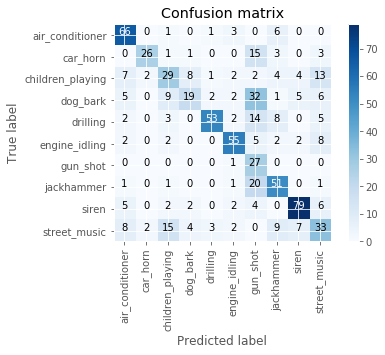

COMET WARNING: Refuse to upload empty figure, please call log_figure before calling show
COMET WARNING: Failing to save the matplotlib figure


<Figure size 432x288 with 0 Axes>

In [35]:
# cm = confusion_matrix(y, y_pred, labels=classes)
conv_mat = confusion_matrix(y, y_pred)
plot = plot_confusion_matrix(conv_mat, classes)
experiment.log_figure(figure=plot,figure_name="Confusion Matrix")

### 2.4 Save model

In [31]:
model_json = model.to_json()
with open(MODELS_DIR/f"{model_name}.json", "w") as json_file:
    json_file.write(model_json)